# Method of moments parameter estimation in Vasicek model

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('..\data\SP_historical_PD_data.csv', sep=';')

In [3]:
df.head()

,Year,Total defaults*,Investment-grade defaults,Speculative-grade defaults,Default rate (%),Investment-grade default rate (%),Speculative-grade default rate (%),Total debt outstanding (bil. $)
0,1981,2,0,2,0.15,0.00,0.63,0.06
1,1982,18,2,15,1.22,0.19,4.46,0.90
2,1983,12,1,10,0.77,0.09,2.98,0.37
3,1984,14,2,12,0.93,0.17,3.31,0.36
4,1985,19,0,18,1.13,0.00,4.37,0.31


In [4]:
# Make pd columns
df["pd_total"] = df["Default rate (%)"] / 100
df["pd_inv"] = df["Investment-grade default rate (%)"] / 100
df["pd_spec"] = df["Speculative-grade default rate (%)"] / 100

In [5]:
# Calculate the number of obligors
df['num_of_inv_grades'] = (df['Investment-grade defaults'] / (df["pd_inv"])).round()
df['num_of_spec_grades'] = (
            df['Speculative-grade defaults'] / (df["pd_spec"])).round().astype(int)
df['num_of_total_grades'] = (df['Total defaults*'] / (df["pd_total"])).round().astype(int)

# Fill-out the missing values in num_of_inv_grades column with the difference between num_of_total_grades and num_of_spec_grades
df['num_of_inv_grades'] = np.where(df['num_of_inv_grades'].isna(), df['num_of_total_grades'] - df['num_of_spec_grades'],
                                   df['num_of_inv_grades']).astype(int)

In [6]:
df[["Year", "num_of_inv_grades", "num_of_spec_grades", "num_of_total_grades"]].iloc[-10:]

,Year,num_of_inv_grades,num_of_spec_grades,num_of_total_grades
30,2011,3333,2378,6625
31,2012,4733,2548,7281
32,2013,4871,2771,7642
33,2014,5571,3125,8696
34,2015,4928,3381,8309
35,2016,3333,3373,7799
36,2017,4491,3360,7851
37,2018,4532,3429,7961
38,2019,3333,3622,9077
39,2020,4648,3600,8248


In [7]:
# Calculate the average
p_total_average = np.mean(df["pd_total"])

In [8]:
print(p_total_average)

0.0147675


In [9]:
# Expected value of 1/n_g
expected_value_of_reciprocal_n_g = np.mean(1 / df['num_of_total_grades'])

In [10]:
print(expected_value_of_reciprocal_n_g)

0.0002769531644134457


In [11]:
# Normalized volatility
normalized_volatility = np.sqrt(np.var(df["pd_total"]))/p_total_average

In [12]:
print(normalized_volatility)

0.6558144744924091


$$
\mathrm{V}\left[p_\zeta(x)\right]=\frac{\mathrm{V}\left[\hat{p}_\zeta\right]-\mathrm{E}\left[1 / \hat{n}_\zeta\right] \bar{p}_\zeta\left(1-\bar{p}_\zeta\right)}{1-\mathrm{E}\left[1 / \hat{n}_\zeta\right]}
$$

In [13]:
variance_of_p_total = (np.var(df["pd_total"]) - expected_value_of_reciprocal_n_g * p_total_average * (1 - p_total_average)) / (1 - expected_value_of_reciprocal_n_g)

In [14]:
print(variance_of_p_total)

8.9789553080102e-05


In [15]:
normalized_varience = np.sqrt(variance_of_p_total) / p_total_average

In [16]:
print(normalized_varience)

0.6416614161184627


In [17]:
cut_off_value_total = stats.norm.ppf(p_total_average)

In [18]:
print(cut_off_value_total)

-2.1762710356300374


$$
V_\zeta \equiv \operatorname{Var}\left[p_\zeta(x)\right]=\operatorname{BIVNOR}\left(C_\zeta, C_\zeta, w_\zeta^2\right)-\bar{p}_\zeta^2
$$

In [19]:
def calc_variance_of_default_rate(w_factor_loading, pd_average = p_total_average):
    
    cut_off_value = stats.norm.ppf(pd_average)
    
    # if w_factor_loading is a np array, take the first element
    if isinstance(w_factor_loading, np.ndarray):
        w_factor_loading = w_factor_loading[0]
    
    # Bivariate normal cdf parameters
    mean = [0, 0]
    cov_matrix = [[1, w_factor_loading**2], [w_factor_loading**2, 1]]
    
     # Calculate BIVNOR value
    bivnor_value = stats.multivariate_normal.cdf([cut_off_value, cut_off_value], mean=mean, cov=cov_matrix)
    
    result = bivnor_value - pd_average ** 2
    
    return result

In [20]:
# Test for calc_variance_of_default_rate
calc_variance_of_default_rate(0.7)

0.0019267238820132938

## Method of moments parameter estimation for w_factor_loading

In [21]:
# Target value to achieve
target_result = variance_of_p_total

# Initial guess for the minimization algorithm
initial_guess = 0.27

# Define bounds for w_factor_loading
bounds = [(-2, 2)]

# Define object function
object_function = lambda w: abs(calc_variance_of_default_rate(w) - target_result)

# Minimization based on the objective function
result = minimize(object_function, initial_guess, bounds=bounds)

# The found value of w_factor_loading
w_factor_loading_found = result.x[0]

print("Found value of w_factor_loading:", w_factor_loading_found)

Found value of w_factor_loading: 0.23741460694825398


## Packaged function for parameter estimation

In [22]:
def estimate_w_factor_loading(historical_pd, num_of_total_grades, initial_guess=0.27):
    """
    Estimate w_factor_loading using the method of moments
    :param historical_pd: pd series, list of historical default rates
    :param num_of_total_grades: pd series, list of the number of total grades
    :param initial_guess: float, initial guess for the minimization algorithm
    :return: float, estimated w_factor_loading
    """
    
    # Calculate the average
    pd_average = np.mean(historical_pd)
    
    if pd_average == 0:
        return 0, pd_average
    
    # Calculate the expected value of 1/n_g
    expected_value_of_reciprocal_n_g = np.mean(1 / num_of_total_grades)
    
    # Variance of default rate
    variance_of_p_d = (np.var(historical_pd) - expected_value_of_reciprocal_n_g * pd_average * (1 - pd_average)) / (1 - expected_value_of_reciprocal_n_g)

    # Define bounds for w_factor_loading
    bounds = [(-5, 5)]

    # Define object function
    object_function = lambda w: abs(calc_variance_of_default_rate(w, pd_average) - variance_of_p_d)

    # Minimization based on the objective function
    result = minimize(object_function, initial_guess, bounds=bounds)

    # The found value of w_factor_loading
    w_factor_loading_found = result.x[0]

    return w_factor_loading_found, pd_average

In [23]:
from scipy.optimize import minimize_scalar

def estimate_w_factor_loading_2(historical_pd, num_of_total_grades):
    """
    Estimate w_factor_loading using the method of moments
    :param historical_pd: pd series, list of historical default rates
    :param num_of_total_grades: pd series, list of the number of total grades
    :param initial_guess: float, initial guess for the minimization algorithm
    :return: float, estimated w_factor_loading
    """
    
    # Calculate the average
    pd_average = np.mean(historical_pd)
    
    if pd_average == 0:
        return 0, pd_average
    
    # Calculate the expected value of 1/n_g
    expected_value_of_reciprocal_n_g = np.mean(1 / num_of_total_grades)
    
    # Variance of default rate
    variance_of_p_d = (np.var(historical_pd) - expected_value_of_reciprocal_n_g * pd_average * (1 - pd_average)) / (1 - expected_value_of_reciprocal_n_g)

    # Define object function
    def object_function(w):
        return abs(calc_variance_of_default_rate(w, pd_average) - variance_of_p_d)

    # Minimization based on the objective function using minimize_scalar
    result = minimize_scalar(object_function, bounds=(0.0001, 1), method='bounded')
    #result = minimize_scalar(object_function, method='golden')
    
    # The found value of w_factor_loading
    w_factor_loading_found = result.x

    return w_factor_loading_found, pd_average

In [24]:
# Test for the packaged function
estimate_w_factor_loading(df["pd_total"], df["num_of_total_grades"])

(0.23741460694825398, 0.0147675)

In [25]:
estimate_w_factor_loading_2(df["pd_total"], df["num_of_total_grades"])

(0.23741624678733297, 0.0147675)

In [26]:
estimate_w_factor_loading(df["pd_inv"], df["num_of_inv_grades"])

(0.27, 0.0008775)

In [27]:
estimate_w_factor_loading_2(df["pd_inv"], df["num_of_inv_grades"])

(0.26963546326126553, 0.0008775)

# Using MM_estimation function from the package

In [28]:
from src.MM_estimation import MM_estimation

# Estimate w_factor_loading for total grades
w_total, pd_total = MM_estimation(df["Total defaults*"], df["num_of_total_grades"])

print("Estimated w_factor_loading for total grades:", w_total)
print("Estimated pd_average for total grades:", pd_total)

Estimated w_factor_loading for total grades: 0.23740645892992832
Estimated pd_average for total grades: -2.17626718586128


In [29]:
from src.MM_estimation import estimate_w_factor_loading
from scipy.stats import norm

param1, param2 = estimate_w_factor_loading(df["pd_total"], df["num_of_total_grades"])
print(param1, norm.ppf(param2))

0.23741460694825398 -2.1762710356300374


# Sensitivity analysis for the initial guess

In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from src.MM_estimation import estimate_w_factor_loading, calc_variance_of_default_rate

# Load the data
grades_data = pd.read_csv('../data/grades_hist_pd.csv', sep=';', index_col=0)

for col_name in grades_data.columns:
    grades_data[col_name] = grades_data[col_name] / 100
    
grades_cols = grades_data.columns

n_g_assumption = 3000
num_of_rows = grades_data.shape[0]
n_g_over_time = np.array([n_g_assumption] * num_of_rows)

In [34]:
MM_params_for_A_grade = estimate_w_factor_loading(grades_data["A"], n_g_over_time, initial_guess=0.45, tolerance=1e-6)
print(f"Estimated parameters with method of moments for grade A:", MM_params_for_A_grade[0], norm.ppf(MM_params_for_A_grade[1]), round(MM_params_for_A_grade[1], 6))

Estimated parameters with method of moments for grade A: 0.4499803380652506 -3.274097580352716 0.00053


In [35]:
MM_params_for_A_grade = estimate_w_factor_loading(grades_data["A"], n_g_over_time, initial_guess=0.45, tolerance=1e-20)
print(f"Estimated parameters with method of moments for grade A:", MM_params_for_A_grade[0], norm.ppf(MM_params_for_A_grade[1]), round(MM_params_for_A_grade[1], 6))

Estimated parameters with method of moments for grade A: 0.34843028136649823 -3.274097580352716 0.00053


In [36]:
MM_params_for_A_grade_2 = estimate_w_factor_loading_2(grades_data["A"], n_g_over_time)
print(f"Estimated parameters with method of moments for grade A:", MM_params_for_A_grade_2[0],
      norm.ppf(MM_params_for_A_grade_2[1]), round(MM_params_for_A_grade_2[1], 6))

Estimated parameters with method of moments for grade A: 0.3484300623921802 -3.274097580352716 0.00053


In [37]:
historical_pd = grades_data["A"]
num_of_total_grades = n_g_over_time
initial_guess = 0.2
# Calculate the average
pd_average = np.mean(historical_pd)

# Calculate the expected value of 1/n_g
expected_value_of_reciprocal_n_g = np.mean(1 / num_of_total_grades)

# Variance of default rate
variance_of_p_d = (np.var(historical_pd) - expected_value_of_reciprocal_n_g * pd_average * (1 - pd_average)) / (
            1 - expected_value_of_reciprocal_n_g)

# Define bounds for w_factor_loading
bounds = [(-0.9999, 0.9999)]

# Define object function
object_function = lambda w: abs(calc_variance_of_default_rate(w, pd_average) - variance_of_p_d)

# Minimization based on the objective function
result = minimize(object_function, initial_guess, bounds=bounds, tol=1e-20)

result.x

array([0.34843028])

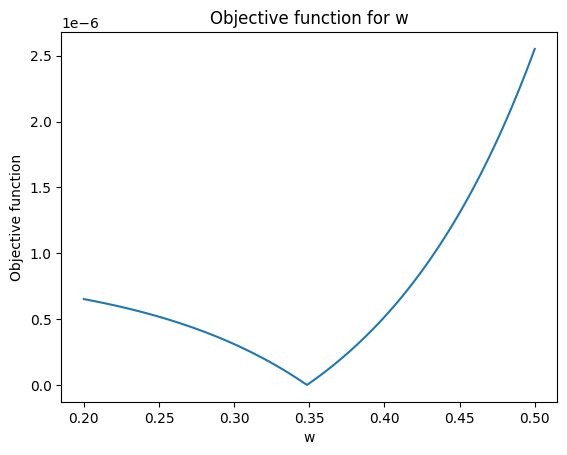

In [38]:
# plot objective function for w
w_values = np.linspace(0.2, 0.5, 100)
objective_values = [object_function(w) for w in w_values]

plt.plot(w_values, objective_values)
plt.xlabel("w")
plt.ylabel("Objective function")
plt.title("Objective function for w")
plt.show()

In [39]:
tol_list = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18, 1e-20]
init_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

w_params_table = pd.DataFrame(columns=tol_list, index=init_list)
for tol in tol_list:
    for init in init_list:
        MM_params_for_A_grade = estimate_w_factor_loading(grades_data["A"], n_g_over_time, initial_guess=init, tolerance=tol)
        w_params_table.loc[init, tol] = MM_params_for_A_grade[0]

In [40]:
w_params_table

,1.000000e-06,1.000000e-08,1.000000e-10,1.000000e-12,1.000000e-14,1.000000e-16,1.000000e-18,1.000000e-20
0.10,0.1,0.100001,0.100001,0.100001,0.34843,0.34843,0.34843,0.34843
0.15,0.150001,0.150001,0.150001,0.34843,0.34843,0.34843,0.34843,0.34843
0.20,0.200002,0.200002,0.200002,0.34843,0.34843,0.34843,0.34843,0.34843
0.25,0.250003,0.250003,0.250003,0.34843,0.34843,0.34843,0.34843,0.34843
0.30,0.300005,0.300005,0.300005,0.34843,0.34843,0.34843,0.34843,0.34843
0.35,0.349992,0.349992,0.349992,0.34843,0.34843,0.34843,0.34843,0.34843
0.40,0.399987,0.399987,0.34843,0.34843,0.34843,0.34843,0.34843,0.34843
0.45,0.44998,0.44998,0.34843,0.34843,0.34843,0.34843,0.34843,0.34843
0.50,0.499969,0.499969,0.34843,0.34843,0.34843,0.34843,0.34843,0.34843


In [41]:
# Compare time of execution for different tolerances
import time

tol_list = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18, 1e-20]
init = 0.30

time_table = pd.DataFrame(columns=["Time (sec)"], index=tol_list)
for tol in tol_list:
    start = time.time()
    MM_params_for_A_grade = estimate_w_factor_loading(grades_data["A"], n_g_over_time, initial_guess=init, tolerance=tol)
    end = time.time()
    time_table.loc[tol, "Time (sec)"] = end - start

In [42]:
time_table

,Time (sec)
1.000000e-06,0.003999
1.000000e-08,0.004003
1.000000e-10,0.002997
1.000000e-12,0.033005
1.000000e-14,0.046003
1.000000e-16,0.041003
1.000000e-18,0.042004
1.000000e-20,0.043


# if w = 1 the variance can not be calculated because the covariance matrix is singular

In [43]:
historical_pd = grades_data["CCC/C"]
#historical_pd = grades_data["A"]
pd_average = np.mean(historical_pd)

expected_value_of_reciprocal_n_g = np.mean(1 / n_g_over_time)

variance_of_p_d = (np.var(historical_pd) - expected_value_of_reciprocal_n_g * pd_average * (1 - pd_average)) / (
                1 - expected_value_of_reciprocal_n_g)

try:
    calc_variance_of_default_rate(1.0, pd_average)
except ValueError as e:
    print(e)

When `allow_singular is False`, the input matrix must be symmetric positive definite.


# Generate default time series and make MM parameter estimation for them

In [44]:
from src.data_generator import generate_default_time_series
import numpy as np

np.random.seed(232345)

time_points = 160
num_of_obligors_list = [3000, 3000, 3000]
factor_loading_list = [0.3, 0.3, 0.3]
gamma_list = [-2.9, -2.3, -1.6]

generated_ts_df = generate_default_time_series(factor_loading_list, num_of_obligors_list, gamma_list, time_points)

In [45]:
generated_ts_df

,d_g_0,d_g_1,d_g_2
0,3,26,168
1,5,28,145
2,6,39,166
3,6,48,207
4,9,65,252
...,...,...,...
155,0,4,36
156,4,19,105
157,15,53,296
158,15,68,352


In [46]:
num_of_obligors_table = num_of_obligors_list[0] * np.ones(generated_ts_df.shape)

In [47]:
defaulted_all = np.array(generated_ts_df.sum(axis=0))

In [48]:
pds = defaulted_all / (num_of_obligors_list[0] * time_points)

In [49]:
from scipy.stats import norm

norm.ppf(pds)

array([-2.87262009, -2.28252551, -1.58197987])

In [50]:
from src.MM_estimation import MM_estimation

# Estimate w_factor_loading for total grades
w_total, pd_total = MM_estimation(generated_ts_df["d_g_2"], num_of_obligors_list[2])

In [51]:
print(w_total, pd_total)

0.29569017016513777 -1.5819798669506395


In [52]:
# Make MM for every grade
MM_params_w = []
MM_params_gamma = []

for i in range(3):
    w_total, pd_total = MM_estimation(generated_ts_df[f'd_g_{i}'], num_of_obligors_list[i])
    print(w_total, pd_total)
    MM_params_w.append(w_total)
    MM_params_gamma.append(pd_total)

0.2742692602339231 -2.872620085589799
0.28323121058277206 -2.28252550695468
0.29569017016513777 -1.5819798669506395


In [53]:
MM_params_w

[0.2742692602339231, 0.28323121058277206, 0.29569017016513777]

# Maximum likelihood estimation

In [54]:
from src.ML_estimation import mle_trapz_g_and_w

mle_results = mle_trapz_g_and_w(generated_ts_df.values, num_of_obligors_table, MM_params_w, MM_params_gamma)

In [55]:
print(mle_results[0])
print(mle_results[1])

[0.31861404 0.3213295  0.32156735]
[-2.85975762 -2.27506712 -1.5795899 ]


# S&P historical data

In [56]:
# Load the data
grades_data = pd.read_csv('../data/grades_hist_pd.csv', sep=';', index_col=0)

for col_name in grades_data.columns:
    grades_data[col_name] = grades_data[col_name] / 100
    
grades_cols = grades_data.columns

In [57]:
grades_cols

Index(['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C'], dtype='object')

In [58]:
expected_value_of_reciprocal_n = {"AAA": 0.0092, "AA": 0.0030, "A":0.0017, "BBB": 0.0026, "BB": 0.0038, "B": 0.0041, "CCC/C": 0.0360}

In [59]:
num_of_obligors_dict = {}
for grade in grades_cols:
    num_of_obligors_dict[grade] = round(1 / expected_value_of_reciprocal_n[grade])

In [60]:
num_of_obligors_dict

{'AAA': 109, 'AA': 333, 'A': 588, 'BBB': 385, 'BB': 263, 'B': 244, 'CCC/C': 28}

In [61]:
average_pd_dict = grades_data.mean().to_dict()
realized_normalized_volatility_dict = np.sqrt(np.var(grades_data)).to_dict()

C:\Users\kissp\PycharmProjects\VasicekPDModell\venv\lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [62]:
unconditional_variance_dict = {}
normalized_unconditional_variance_dict = {}
for grade in grades_cols:
    unconditional_variance_dict[grade] = (np.var(grades_data[grade]) - expected_value_of_reciprocal_n[grade] * average_pd_dict[grade] * (1 - average_pd_dict[grade])) / (1 - expected_value_of_reciprocal_n[grade])
    normalized_unconditional_variance_dict[grade] = np.sqrt(unconditional_variance_dict[grade]) / average_pd_dict[grade]

C:\Users\kissp\AppData\Local\Temp\ipykernel_29756\3340296430.py:5: RuntimeWarning: invalid value encountered in scalar divide
  normalized_unconditional_variance_dict[grade] = np.sqrt(unconditional_variance_dict[grade]) / average_pd_dict[grade]


In [63]:
# Make a pandas dataframe
# Columns: average_pd, expected_value_of_reciprocal_n, realized_normalized_volatility, normalized_unconditional_variance
# Rows: grades
# Round the values to 4 decimal places
df = pd.DataFrame([average_pd_dict, expected_value_of_reciprocal_n, realized_normalized_volatility_dict, normalized_unconditional_variance_dict],
                  index=["average_pd", "expected_value_of_reciprocal_n", "realized_normalized_volatility", "normalized_unconditional_variance"]).T
df = df.round(6)

In [64]:
df

,average_pd,expected_value_of_reciprocal_n,realized_normalized_volatility,normalized_unconditional_variance
AAA,0.000000,0.0092,0.000000,NaN
AA,0.000137,0.0030,0.000644,0.317527
A,0.000530,0.0017,0.001002,0.604811
BBB,0.001948,0.0026,0.002512,0.575950
BB,0.008558,0.0038,0.009781,0.932466
B,0.041913,0.0041,0.032031,0.701685
CCC/C,0.249192,0.0360,0.116456,0.337697


In [65]:
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & average_pd & expected_value_of_reciprocal_n & realized_normalized_volatility & normalized_unconditional_variance \\
\midrule
AAA & 0.000000 & 0.009200 & 0.000000 & NaN \\
AA & 0.000137 & 0.003000 & 0.000644 & 0.317527 \\
A & 0.000530 & 0.001700 & 0.001002 & 0.604811 \\
BBB & 0.001948 & 0.002600 & 0.002512 & 0.575950 \\
BB & 0.008558 & 0.003800 & 0.009781 & 0.932466 \\
B & 0.041913 & 0.004100 & 0.032031 & 0.701685 \\
CCC/C & 0.249192 & 0.036000 & 0.116456 & 0.337697 \\
\bottomrule
\end{tabular}


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from src.MM_estimation import gen_data_and_mm

In [67]:
factor_loading_list = [0.45, 0.45, 0.45]
pd_list = [0.0015, 0.0100, 0.0500]
# pd_list2 = [0.005, 0.0100, 0.0500]
gamma_list = norm.ppf(pd_list)
num_of_obligors_list = [400, 250, 100]

# Make a pandas dataframe with Grade, Factor Loading, PD, Gamma, Num of Obligors
df = pd.DataFrame({'Grade': ['A', 'B', 'C'], 'Factor Loading': factor_loading_list, 'PD': pd_list, 'Gamma': gamma_list, 'Num of Obligors': num_of_obligors_list})
df

,Grade,Factor Loading,PD,Gamma,Num of Obligors
0,A,0.45,0.0015,-2.967738,400
1,B,0.45,0.0100,-2.326348,250
2,C,0.45,0.0500,-1.644854,100


In [68]:
params_df_160 = gen_data_and_mm(160, num_of_obligors_list, factor_loading_list, gamma_list, sims=500)

In [75]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import norm
from src.data_generator import generate_default_time_series

def gen_data_and_mm_2(time_points, num_of_obligors_list, factor_loading_list, gamma_list, sims=100):
    """
    Generate data and estimate parameters using the method of moments estimation method.
    :param time_points: int, number of time points
    :param num_of_obligors_list: list, number of obligors for each grade
    :param factor_loading_list: list, factor loading for each grade
    :param gamma_list: list, gamma for each grade
    :param sims: int, number of simulations
    """
    grade_num = len(gamma_list)

    params_df = pd.DataFrame()

    for sim in range(sims):
        defaults_df = generate_default_time_series(factor_loading_list, num_of_obligors_list, gamma_list, time_points)
        for i in range(grade_num):
            n_g_list = np.array([num_of_obligors_list[i]] * time_points)
            w_param, gamma_param = MM_estimation_2(defaults_df["d_g_" + str(i)], n_g_list)
            params_df.loc[sim, "gamma_" + str(i)] = gamma_param
            params_df.loc[sim, "w_" + str(i)] = w_param

    return params_df

In [77]:
def MM_estimation_2(default_series, num_of_obligors_series):
    """
    Estimate w_g and gamma_g using the MM estimation method.

    Returns:
        tuple: Estimated w_g and gamma_g.
    """
    historical_pd = default_series / num_of_obligors_series

    # Estimate w_factor_loading
    w_g, pd_average = estimate_w_factor_loading_2(historical_pd, num_of_obligors_series)

    return w_g, norm.ppf(pd_average)

In [71]:
params_df_160 = gen_data_and_mm(160, num_of_obligors_list, factor_loading_list, gamma_list, sims=500)

In [72]:
params_df_20 = gen_data_and_mm(20, num_of_obligors_list, factor_loading_list, gamma_list, sims=100)

In [78]:
params_df_20_2 = gen_data_and_mm_2(20, num_of_obligors_list, factor_loading_list, gamma_list, sims=100)

In [79]:
params_df_160_2 = gen_data_and_mm_2(160, num_of_obligors_list, factor_loading_list, gamma_list, sims=500)

In [80]:
params_df_20.describe()

,gamma_0,w_0,gamma_1,w_1,gamma_2,w_2
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,-3.001825,0.320252,-2.340365,3.768191e-01,-1.641522,0.408198
std,0.182208,0.094239,0.146119,9.750652e-02,0.125981,0.083768
min,-3.662260,0.000003,-2.820158,5.314797e-07,-1.995393,0.223695
25%,-3.129675,0.269993,-2.411222,3.316930e-01,-1.712801,0.347663
50%,-2.994384,0.295477,-2.337772,3.788216e-01,-1.635253,0.409056
75%,-2.893386,0.378291,-2.263579,4.310218e-01,-1.567491,0.460149
max,-2.567279,0.662374,-1.933294,7.407272e-01,-1.298837,0.697684


In [81]:
params_df_20_2.describe()

,gamma_0,w_0,gamma_1,w_1,gamma_2,w_2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-3.028009,0.292022,-2.354358,0.387725,-1.674470,0.411279
std,0.177400,0.164966,0.129590,0.105831,0.113578,0.094249
min,-3.480756,0.000103,-2.687449,0.056965,-1.968592,0.217658
25%,-3.129675,0.221609,-2.447127,0.311185,-1.757991,0.346577
50%,-3.023341,0.309846,-2.357469,0.381625,-1.674665,0.421356
75%,-2.914636,0.421381,-2.263579,0.454158,-1.593714,0.457150
max,-2.534836,0.607579,-1.959964,0.756359,-1.368998,0.700950


In [82]:
params_df_160.describe()

,gamma_0,w_0,gamma_1,w_1,gamma_2,w_2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-2.975659,0.418155,-2.330747,0.437204,-1.648949,0.444306
std,0.061947,0.062751,0.049260,0.047730,0.042565,0.036622
min,-3.157048,0.188595,-2.492073,0.312981,-1.773626,0.342890
25%,-3.015862,0.377063,-2.360761,0.404532,-1.677377,0.419793
50%,-2.974204,0.415394,-2.329171,0.434645,-1.650944,0.443337
75%,-2.934231,0.455831,-2.298207,0.465582,-1.621082,0.467508
max,-2.783656,0.632561,-2.159002,0.612375,-1.509680,0.559142


In [83]:
params_df_160_2.describe()

,gamma_0,w_0,gamma_1,w_1,gamma_2,w_2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-2.974909,0.417787,-2.329986,0.437640,-1.647110,0.443163
std,0.064943,0.058988,0.048681,0.045626,0.042639,0.036665
min,-3.174684,0.262933,-2.496290,0.319171,-1.785070,0.333891
25%,-3.015862,0.377333,-2.362544,0.406081,-1.677377,0.418547
50%,-2.974204,0.413275,-2.332489,0.434320,-1.647587,0.442544
75%,-2.928479,0.454077,-2.298867,0.464465,-1.618755,0.466372
max,-2.785547,0.654074,-2.196586,0.667710,-1.533105,0.599632
